In [5]:
import os
import pickle
import scipy.signal
from scipy import fft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# No tensorflow import needed if only predicting with LightGBM/XGBoost
from lightgbm import LGBMClassifier # Needed for type hinting and clarity if you use it directly
# Or import xgboost as xgb if you plan to use an XGBoost model here
import joblib # Used for loading models saved with joblib, or you can use pickle

# --- Re-define essential preprocessing components from model.ipynb ---

# Adjust DATA_PATH if your WESAD data is in a different location relative to this script
DATA_PATH = os.path.realpath("../WESAD") # Assuming WESAD folder is one level up from this script

class Subject:
    """Subject of the WESAD dataset."""
    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP'] # All available wrist sensors
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        data = self.data['signal']['wrist']
        return data
    
    def get_subject_dataframe(self):
        """Returns a dataframe with the preprocessed data of the subject"""
        wrist_data = self.get_wrist_data()
        bvp_signal = wrist_data['BVP'][:,0]
        eda_signal = wrist_data['EDA'][:,0]
        acc_x_signal = wrist_data['ACC'][:,0]
        acc_y_signal = wrist_data['ACC'][:,1]
        acc_z_signal = wrist_data['ACC'][:,2]
        temp_signal = wrist_data['TEMP'][:,0]
        eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
        temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
        acc_x_upsampled = scipy.signal.resample(acc_x_signal, len(bvp_signal))
        acc_y_upsampled = scipy.signal.resample(acc_y_signal, len(bvp_signal))
        acc_z_upsampled = scipy.signal.resample(acc_z_signal, len(bvp_signal))
        label_df = pd.DataFrame(self.labels, columns=['label'])
        label_df.index = [(1 / 700) * i for i in range(len(label_df))]
        label_df.index = pd.to_datetime(label_df.index, unit='s')
        data_arrays = zip(bvp_signal, eda_upsampled, acc_x_upsampled, acc_y_upsampled, acc_z_upsampled, temp_upsampled)
        df = pd.DataFrame(data=data_arrays, columns=['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'])
        df.index = [(1 / 64) * i for i in range(len(df))]
        df.index = pd.to_datetime(df.index, unit='s')
        df = df.join(label_df)
        df['label'] = df['label'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        df.drop(df[df['label'].isin([0.0, 4.0, 5.0, 6.0, 7.0])].index, inplace=True)
        df['label'] = df['label'].replace([1.0, 2.0, 3.0], [0, 1, 0])
        df.reset_index(drop=True, inplace=True)
        df = (df-df.min())/(df.max()-df.min())
        return df

# Subwindow length of the biosignals (must match training)
signal_subwindow_dict = {
    'ACC_x': 7, 'ACC_y': 7, 'ACC_z': 7,
    'BVP': 30, 'EDA': 30, 'TEMP': 35
}

def most_common(lst):
    return max(set(lst), key=lst.count)

def create_windows(df: pd.DataFrame) -> tuple[list,list]:
    window_len = 64 * 60
    windows_list = []
    labels_list = []
    for i in range(0,df.shape[0],window_len):
        window_data = df[i:i+window_len]
        if not window_data.empty:
            windows_list.append(window_data)
            # Labels not strictly needed for prediction, but kept for consistency
            labels_list.append(int(most_common(window_data['label'].to_list()))) 
    return windows_list, labels_list

def create_subwindows(df: pd.DataFrame, signal_subwindow_len: int, signal_name: str) -> list:
    subwindow_len = 64 * signal_subwindow_len
    window_len = 64 * 60
    window_shift = int(64 * 0.25)
    subwindows = []
    for i in range(0, window_len, window_shift):
        if i + subwindow_len <= window_len:
            subwindow = df[signal_name][i:i+subwindow_len]
            if not subwindow.empty:
                subwindows.append(subwindow)
    return subwindows
            
def fft_subwindows(subwindows: list, duration: int, f_s: int) -> tuple[np.ndarray, np.ndarray]:
    freqs = []
    yfs = []
    for subwindow in subwindows:
        y = np.array(subwindow)
        if len(y) == 0:
            continue
        yf = scipy.fft.fft(y)
        l = len(yf)
        N = f_s * duration
        if N == 0: 
            freq = np.array([])
        else:
            freq = scipy.fft.fftfreq(N, 1/f_s)
        l //= 2
        amps = np.abs(yf[0:l])
        freq = np.abs(freq[0:l])
        if amps.size > 0:
            p = amps.argsort()[::-1]
            freq = freq[p]
            amps = amps[p]
        freqs.append(freq)
        yfs.append(amps)
    return np.asarray(freqs, dtype=object), np.asarray(yfs, dtype=object)
    
def average_window(subwindows_fft: np.ndarray) -> list:
    valid_yfs = [yf for yf in subwindows_fft if yf.size > 0]
    if not valid_yfs:
        return [0] * 210
    max_len_yfs = max(len(yf) for yf in valid_yfs)
    avg_yfs = []
    for i in range(max_len_yfs):
        i_yfs = []
        for yf in valid_yfs:
            if i < len(yf):
                i_yfs.append(yf[i])
        if i_yfs:
            avg_yfs.append(sum(i_yfs)/len(i_yfs))
        else:
            avg_yfs.append(0)
    return avg_yfs

# --- Function to preprocess new raw data into model input format ---
def preprocess_new_raw_data(raw_data_df: pd.DataFrame) -> np.ndarray:
    """
    Takes raw sensor data for a new individual/period (as a DataFrame from get_subject_dataframe)
    and processes it into the flattened 2D NumPy array format required by the LightGBM/XGBoost model.
    """
    processed_windows_features = []
    
    # Apply windowing to the new raw data
    new_subject_windows, _ = create_windows(raw_data_df) # _ because labels aren't strictly needed for prediction

    # Extract features (FFT and averaging) for each window
    signal_columns = ['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'] # Must match training columns
    
    for window_df_raw in new_subject_windows:
        if not isinstance(window_df_raw, pd.DataFrame) or window_df_raw.empty:
            continue # Skip empty windows

        yfs_per_min_for_signal = {}
        for signal in signal_columns: # Iterate through the expected signals
            duration_in_sec = signal_subwindow_dict[signal] # Use your signal_subwindow_dict

            # Generate subwindows for this signal
            # This part needs to mimic create_subwindows and then feed into fft_subwindows
            subwindows_for_signal = []
            subwindow_len = 64 * duration_in_sec
            window_len = 64 * 60
            window_shift = int(64 * 0.25)
            
            if signal in window_df_raw.columns: # Ensure the signal column exists in this window
                for i in range(0, window_len, window_shift):
                    if i + subwindow_len <= window_len:
                        subwindow_data = window_df_raw[signal][i:i+subwindow_len]
                        if not subwindow_data.empty:
                            subwindows_for_signal.append(subwindow_data)
            
            if not subwindows_for_signal:
                yfs_average = [0] * 210 # Fill with zeros if no subwindows were created
            else:
                freqs, yfs = fft_subwindows(subwindows_for_signal, duration_in_sec, 64)
                if yfs.size == 0:
                    yfs_average = [0] * 210
                else:
                    yfs_average = average_window(yfs)
            
            if len(yfs_average) < 210:
                yfs_average.extend([0] * (210 - len(yfs_average)))
            yfs_per_min_for_signal[signal] = yfs_average[:210]
        
        # Create a temporary DataFrame from the extracted features for this window
        current_window_features_df = pd.DataFrame(yfs_per_min_for_signal).T
        
        # Flatten this window's features into a 1D numpy array
        processed_windows_features.append(current_window_features_df.values.flatten())

    # Stack all flattened windows into a single 2D NumPy array for model input
    if processed_windows_features:
        final_X_for_prediction = np.array(processed_windows_features)
    else:
        print("Warning: No valid feature data could be extracted from the new raw input.")
        final_X_for_prediction = np.empty((0, len(signal_columns) * 210)) # Empty array if no data

    return final_X_for_prediction



#### Prediction 

Successfully loaded model from: lgbmmodels/lightgbm_model_S7.pkl

Simulating new data acquisition for Subject S7...


/var/folders/lw/14dpn8b91z99svtdtfqnx09800tlp4/T/ipykernel_72770/1911158369.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['label'] = df['label'].fillna(method='ffill')


Preprocessing new data for prediction...
Shape of prepared new data for prediction: (37, 1260)


/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


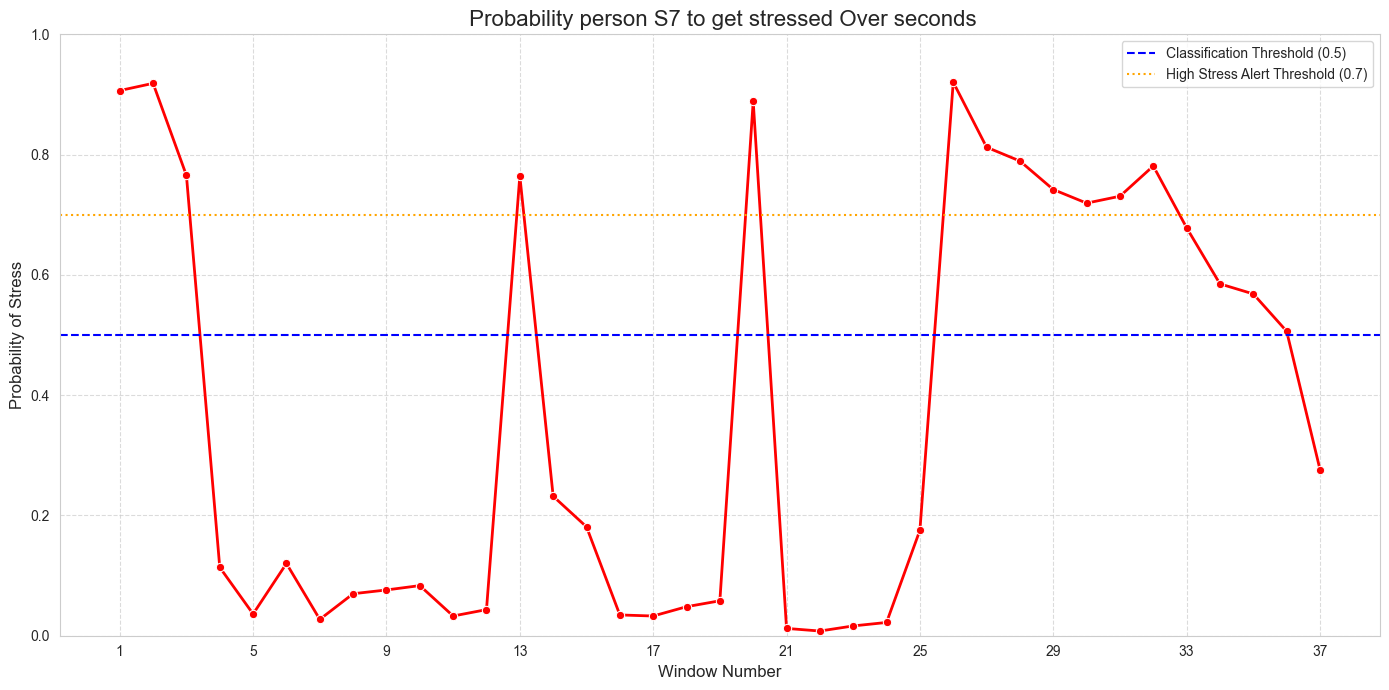


--- Detailed Prediction Results ---
Window 1: Predicted Status: Stress, Probability (Non-Stress/Stress): [0.0934, 0.9066]
  -> High probability of stress detected (P=0.91). Consider proactive intervention.
Window 2: Predicted Status: Stress, Probability (Non-Stress/Stress): [0.0813, 0.9187]
  -> High probability of stress detected (P=0.92). Consider proactive intervention.
Window 3: Predicted Status: Stress, Probability (Non-Stress/Stress): [0.2345, 0.7655]
  -> High probability of stress detected (P=0.77). Consider proactive intervention.
Window 4: Predicted Status: Non-Stress, Probability (Non-Stress/Stress): [0.8863, 0.1137]
  -> Low probability of stress (P=0.11).
Window 5: Predicted Status: Non-Stress, Probability (Non-Stress/Stress): [0.9638, 0.0362]
  -> Low probability of stress (P=0.04).
Window 6: Predicted Status: Non-Stress, Probability (Non-Stress/Stress): [0.8799, 0.1201]
  -> Low probability of stress (P=0.12).
Window 7: Predicted Status: Non-Stress, Probability (Non-Str

In [8]:
SAVED_MODELS_DIR = "lgbmmodels" 


MODEL_TO_LOAD_FILENAME = "lightgbm_model_S7.pkl" 
MODEL_PATH = os.path.join(SAVED_MODELS_DIR, MODEL_TO_LOAD_FILENAME)

# --- Load the Trained Model ---
loaded_model = None
try:
    with open(MODEL_PATH, 'rb') as file:
        loaded_model = pickle.load(file)
    print(f"Successfully loaded model from: {MODEL_PATH}")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_PATH}.")
    print("Please ensure you have run the training script and the model file exists.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    exit()


SUBJECT_FOR_PREDICTION = 7 # Subject ID 
print(f"\nSimulating new data acquisition for Subject S{SUBJECT_FOR_PREDICTION}...")
new_subject_raw_data_df = Subject(DATA_PATH, SUBJECT_FOR_PREDICTION).get_subject_dataframe()

# --- Preprocess the New Data ---
print("Preprocessing new data for prediction...")
new_X_for_prediction = preprocess_new_raw_data(new_subject_raw_data_df)

print(f"Shape of prepared new data for prediction: {new_X_for_prediction.shape}")

# --- Make Predictions ---
if loaded_model is not None and new_X_for_prediction.shape[0] > 0:
    predictions = loaded_model.predict(new_X_for_prediction)
    probabilities = loaded_model.predict_proba(new_X_for_prediction)

    # Extract the probability of the stress class (usually the second column, index 1)
    stress_probabilities = probabilities[:, 1]

    # Create a time index or simply use the window number for the x-axis
    window_numbers = np.arange(1, len(stress_probabilities) + 1)

    # --- Plotting the probabilities ---
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")

    sns.lineplot(x=window_numbers, y=stress_probabilities, marker='o', color='red', linewidth=2)

    # Add a threshold line (e.g., 0.5 for classification, or a higher threshold for "high stress")
    plt.axhline(y=0.5, color='blue', linestyle='--', label='Classification Threshold (0.5)')
    plt.axhline(y=0.7, color='orange', linestyle=':', label='High Stress Alert Threshold (0.7)')

    plt.title(f' Probability person S{SUBJECT_FOR_PREDICTION} to get stressed Over seconds', fontsize=16)
    plt.xlabel('Window Number', fontsize=12)
    plt.ylabel('Probability of Stress', fontsize=12)
    plt.ylim(0, 1)
    plt.xticks(window_numbers if len(window_numbers) < 20 else np.linspace(window_numbers.min(), window_numbers.max(), 10, dtype=int)) # Adjust ticks for readability
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\n--- Detailed Prediction Results ---")
    for i, pred in enumerate(predictions):
        stress_status = "Stress" if pred == 1 else "Non-Stress"
        prob_non_stress = probabilities[i][0]
        prob_stress = probabilities[i][1]
        
        print(f"Window {i+1}: Predicted Status: {stress_status}, Probability (Non-Stress/Stress): [{prob_non_stress:.4f}, {prob_stress:.4f}]")

        if prob_stress > 0.7:
            print(f"  -> High probability of stress detected (P={prob_stress:.2f}). Consider proactive intervention.")
        elif prob_stress > 0.5:
            print(f"  -> Moderate probability of stress (P={prob_stress:.2f}). Monitor closely.")
        else:
            print(f"  -> Low probability of stress (P={prob_stress:.2f}).")
else:
    print("No model loaded or no valid data available for prediction.")